In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.append(str(PROJECT_ROOT))

from src.markov_shapley import (
    create_user_journeys,
    create_transition_matrix,
    extract_q_matrix,
    extract_r_matrix,
    compute_fundamental_matrix,
    removal_effects,
    preprocess_for_shapley,
    compute_shapley,
    top_converting_paths
)


from src.attr_synthesis import synthesize_attribution_prior

from src.viz_forest import plot_prior_distributions

from src.viz import generate_sankey_pro




In [2]:
import inspect
from src.markov_shapley import top_converting_paths

print(inspect.getsource(top_converting_paths))


def top_converting_paths(
    df_paths,
    journey_col="user_journey",
    result_col="result",
    top_n=10,
    min_conversions=1,
):
    """
    Returns the top converting channel paths with collective contribution.
    Robust to all pandas versions.
    """

    converted = df_paths[df_paths[result_col] == "conversion"]

    cleaned_paths = converted[journey_col].apply(
        lambda p: tuple(
            ch for ch in p
            if ch not in ("start", "conversion", "dropped")
        )
    )

    path_counts = (
        cleaned_paths
        .groupby(cleaned_paths)
        .size()
        .reset_index(name="conversions")
        .rename(columns={journey_col: "path"})
    )

    path_counts = path_counts[path_counts["conversions"] >= min_conversions]

    if path_counts.empty:
        return pd.DataFrame(columns=["path", "conversions", "share_of_conversions_pct"])

    total_conversions = path_counts["conversions"].sum()

    path_counts["share_of_conversions_pct"] = (
        

In [3]:
def canonical_channel_name(x: str) -> str:
    x = str(x).strip().lower()
    for ch in ["&", "-", " ", "/", "\\", ".", ",", ":"]:
        x = x.replace(ch, "_")
    while "__" in x:
        x = x.replace("__", "_")
    return x.strip("_")


In [4]:
ga_df = pd.read_csv(r"C:\Users\Krina\atlas\data\ga_2.csv")




ga_df.head()


C:\Users\Krina\AppData\Local\Temp\ipykernel_11520\1475844024.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ga_df = pd.read_csv(r"C:\Users\Krina\atlas\data\ga_2.csv")


,user_id,session_time,channel,converted
0,7748782825261851002,2017-05-05 18:29:57 UTC,(Other),False
1,7748782825261851002,2017-05-05 18:19:37 UTC,(Other),False
2,9813549014448545779,2017-05-17 18:57:25 UTC,(Other),False
3,0964784969815496083,2017-05-19 16:48:36 UTC,(Other),False
4,5302771102738976470,2017-07-22 21:48:45 UTC,(Other),False


In [5]:
# Build journeys
df_paths = create_user_journeys(ga_df)
df_paths

,user_id,session_time,channel_list,converted,Timestamp,result,user_journey
0,62349695125717,[2017-06-07 06:34:00 UTC],[referral],[False],[2017-06-07 06:34:00+00:00],dropped,"[start, referral, dropped]"
1,170187170673177,"[2017-06-08 18:28:30 UTC, 2017-06-08 21:18:32 ...","[referral, referral, referral, referral, refer...","[False, False, False, False, False, False, Fal...","[2017-06-08 18:28:30+00:00, 2017-06-08 21:18:3...",dropped,"[start, referral, referral, referral, referral..."
2,197671390269035,[2017-05-03 00:54:30 UTC],[social],[False],[2017-05-03 00:54:30+00:00],dropped,"[start, social, dropped]"
3,277260039178149,[2017-07-15 08:06:37 UTC],[social],[False],[2017-07-15 08:06:37+00:00],dropped,"[start, social, dropped]"
4,293088006393965,"[2017-07-16 23:10:40 UTC, 2017-07-17 08:56:29 ...","[social, social]","[False, False]","[2017-07-16 23:10:40+00:00, 2017-07-17 08:56:2...",dropped,"[start, social, social, dropped]"
...,...,...,...,...,...,...,...
165537,9999594748540438502,"[2017-06-03 16:43:51 UTC, 2017-07-05 13:56:33 ...","[direct, organic search]","[False, False]","[2017-06-03 16:43:51+00:00, 2017-07-05 13:56:3...",dropped,"[start, direct, organic search, dropped]"
165538,9999773079368714197,[2017-06-11 19:43:43 UTC],[organic search],[False],[2017-06-11 19:43:43+00:00],dropped,"[start, organic search, dropped]"
165539,9999799804624735268,[2017-06-11 20:25:17 UTC],[organic search],[False],[2017-06-11 20:25:17+00:00],dropped,"[start, organic search, dropped]"
165540,9999825631375939274,[2017-06-01 14:58:59 UTC],[organic search],[False],[2017-06-01 14:58:59+00:00],dropped,"[start, organic search, dropped]"


In [6]:
# Transition matrices
count_df, prob_df = create_transition_matrix(ga_df, df_paths)

In [7]:
# Markov components
absorbing_states = ['conversion','dropped']

Q, transient_states = extract_q_matrix(prob_df)
R, _ = extract_r_matrix(prob_df, absorbing_states)
N = compute_fundamental_matrix(Q)

In [8]:
# MARKOV output (pp)
markov_removal_pp = removal_effects(
    prob_df=prob_df,
    absorbing_states=absorbing_states,
    baseline_N=N,
    R_matrix=R
)

In [9]:
sankey_plot = generate_sankey_pro(df_paths)

In [10]:
# SHAPLEY output (%)
shap_df = preprocess_for_shapley(df_paths)
shapley_pct = compute_shapley(shap_df)

In [11]:
markov_removal_pp

referral          0.80
organic search    0.51
direct            0.31
paid search       0.09
social            0.03
display           0.02
(other)           0.00
affiliates        0.00
dtype: float64

In [12]:
shapley_pct

organic search    56.11
direct            18.65
referral          11.29
social             7.96
paid search        3.33
affiliates         2.14
display            0.52
(other)            0.00
dtype: float64

In [13]:
top_paths = top_converting_paths(
    df_paths,
    top_n=10,
    min_conversions=5
)

top_paths


,path,conversions,share_of_conversions_pct
0,referral,446,16.62
1,organic search,381,14.20
2,referral → referral,293,10.92
3,direct,256,9.54
4,referral → referral → referral,209,7.79
5,organic search → organic search,189,7.04
6,direct → direct,116,4.32
7,referral → referral → referral → referral,114,4.25
8,organic search → organic search → organic search,78,2.91
9,referral → referral → referral → referral → re...,69,2.57


In [14]:
prior_df = synthesize_attribution_prior(
    markov_removal_pp=markov_removal_pp,
    shapley_pct=shapley_pct,
    mmm_channels=None  # or pass MMM channels later
)

prior_df


,channel,attr_weight,source,confidence,markov_weight,shapley_weight
0,organic_search,3.983032e-01,markov+shapley,0.433681,0.289773,0.5611
1,referral,3.178870e-01,markov+shapley,0.251835,0.454545,0.1129
2,direct,1.802816e-01,markov+shapley,0.745820,0.176136,0.1865
3,paid_search,4.400177e-02,markov+shapley,0.642440,0.051136,0.0333
4,social,4.206723e-02,markov+shapley,0.403514,0.017045,0.0796
5,display,8.898173e-03,markov+shapley,0.701653,0.011364,0.0052
6,affiliates,8.559991e-03,shapley_only,0.546218,0.000000,0.0214
7,(other),9.999990e-07,none,0.100000,0.000000,0.0000


Channel              | Weight   | Conf   | Sigma    | Implied Range (±2σ)
-------------------------------------------------------------------------------------
organic_search       | 0.3983   | 0.43   | 0.0691   | 0.260 - 0.537
referral             | 0.3179   | 0.25   | 0.0873   | 0.143 - 0.493
direct               | 0.1803   | 0.75   | 0.0379   | 0.104 - 0.256
paid_search          | 0.0440   | 0.64   | 0.0483   | 0.000 - 0.141
social               | 0.0421   | 0.40   | 0.0721   | 0.000 - 0.186
display              | 0.0089   | 0.70   | 0.0423   | 0.000 - 0.094
affiliates           | 0.0086   | 0.55   | 0.0579   | 0.000 - 0.124


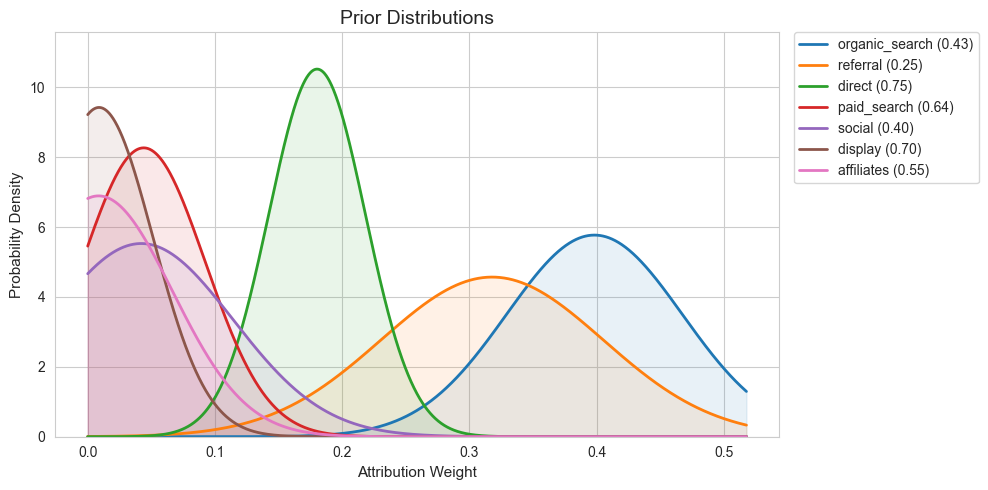

In [15]:
df_with_sigmas = plot_prior_distributions(
    prior_df,           # <--- Insert your output DataFrame here
    min_rel_sigma=0.1,  # Tightest allowed (10% error margin)
    max_rel_sigma=0.9   # Loosest allowed (90% error margin)
)